<h1>HCOPE turorial</h1>

In [1]:
import gym
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import floor,exp,log
from torch import as_tensor
from statistics import mean,stdev
from stable_baselines3 import PPO

<h3> Introduction to SB3 using the Cart-Pole environment </h3>

Using SB3 (https://stable-baselines3.readthedocs.io/en/master/) we can easily train agents on existing OpenAI gym environments. 


Create agent for the Cart-Pole environment and train for $5000$ steps. Which is described as follows:

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. 

(Further Information: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('CartPole-v1') #intialise environment 
agent = PPO("MlpPolicy", env, verbose=0) #initialise agent using PPO for learning
agent.set_env(env)

'train agent for 5000 steps'

agent.learn(total_timesteps=int(5000))

Modeling one episode of Cart-Pole, played by `agent` can be done as follows. First sample the initial state `s` using the agent's environment `agent.get_env()`. Let `agent`choose the next action `a` and get the next state `s` using the agent's environment. Repeat while the environment has not terminated.

Each state `s` the agent has to choose one of two possible actions, either `a=0` or `a=1`, i.e. move the cart to the left or right. `agent.policy` returns the policy $\pi$ which we can use to compute 

\begin{align}
\pi(a|s) \text{ probability of taking action $a$ given the state $s$}
\end{align}. 

`agent.policy.get_distribution(s)` returns $\pi(.|s)$ for the state `s`. Sampling `agent.policy.get_distribution(s).sample()` returns the next action taken by the agent. 

Now sample the inital state `s` and print the distribution of actions in state `s`.

In [4]:
s = agent.get_env().reset()
d = agent.policy.get_distribution(as_tensor(s,device=DEVICE))
for i in range(2):
    a = as_tensor(i,device=DEVICE)
    direction = 'left' if i==0 else 'right'
    print('pi(%s|s)=%f'%(direction,exp(d.log_prob(a))))

pi(left|s)=0.493600
pi(right|s)=0.506400


Simulate one episode and visualise decision making.

In [5]:
def decision(agent,upper=None,axs=None,title=None):
    '''get policy'''
    policy = agent.policy 
    '''sample initial state distribution for first state s (from agents env)'''
    state = agent.get_env().reset() 
    '''indicates if environment terminated (agent lost or game has ended)'''
    done = False 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    probs = [] 
    actions = []
    
    '''while the game is not over'''
    while not done: 
        distribution = policy.get_distribution(as_tensor(state,device=device)) #pass state as torch tensor
        '''get next action'''
        action = distribution.sample() 
        '''collect log(pi(a|s))'''
        probs.append(distribution.log_prob(action).item())
        '''next state and check if env terminated'''
        state,reward,done,_ = agent.get_env().step(action.numpy()) 
        actions.append(action.item())
      

    '''plot probability of action taken at step i'''
    
    plot_len = min(50,len(probs))
    x_vals = np.arange(plot_len)
    N = agent.get_env().action_space.n
    cols = plt.cm.rainbow(np.linspace(0,1,N))
    maxy = 0
    
    for i in range(N):
        data = [(x,exp(p)) for x,p,a in zip(x_vals,probs,actions) if a==i]
        if(len(data)!=0):
            x,y = zip(*data)
            axs.scatter(x,y,color=cols[i],label=r'action='+str(i))
            maxy = max(maxy,max(y))
        
    upper = upper if upper!=None else maxy
    
    axs.axhline(y=upper,color='red',linestyle='dotted',label='upper')
    axs.set_xlabel('step')
    axs.set_ylabel(r'$\pi(a_x|s_x)$')
    axs.set_ylim(0,1.15)
    axs.set_title(title)
    axs.legend(loc='upper center',ncol=3)

    return upper

Import agent trained for $10 000$ steps and compare how greedy agents are when deciding on which action to take.

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


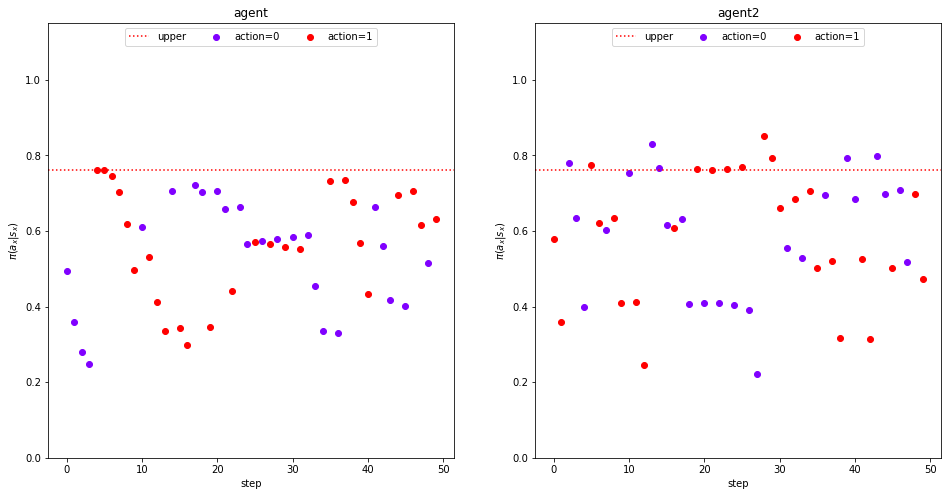

In [6]:
agent2 = PPO.load("trained_models/CartPole-10k") 
agent2.set_env(env)

fig,axs = plt.subplots(1,2,figsize=(16,8))

upper = decision(agent,axs=axs[0],title='agent')
upper = decision(agent2,upper=upper,axs=axs[1],title='agent2')

The red dotted line shows the upper bound for values visualised in previous plot. Observe that all dots, in the first plot, are bounded by $\approx 0.8$  but many dots in the second plot have $y-$values larger than $0.8$. This indicates that `agent2` tends to be more greedy when deciding which action to take. 

<h2>Problem description and definitions</h2>

Assume we have trained some agent $e$, on some environment `env`, but the we can not simulate trajectories generated by $e$. Let $\pi_e$ denote the policy of agent $e$, i.e. the evaluation-policy. The goal is to compute lower bounds for the expected return $e$ generates, by observing how other agents behave (behaviour-agents). From now on we assume that the sets $\mathcal{S},\mathcal{A}$ of possible states and actions are finite.

For $\displaystyle L\in \mathbb{N}$, some policy $\pi$ and environment `env` define the random variables

\begin{equation*}
\Xi _{i} :=( S_{i} ,A_{i} ,R_{i}) ,\ 1\leqslant i\leqslant L \text{and} \  H_{L} :=( \Xi _{i})_{i=1}^{L} \ 
\end{equation*}


$\displaystyle H_{L}$ dentoes the history of states, actions and rewards in an epsiode of length $\displaystyle L$. Let $\displaystyle \xi =( s_{i} ,a_{i} ,r_{i})$, $\displaystyle h_{L} =( \xi _{i})_{i=1}^{L}$ denote a sample from $\displaystyle H_{L}$, i.e 

\begin{equation*}
S_i\rightarrow s_i\in\mathcal{S}, A_i\rightarrow a_i\in\mathcal{A}, R_i\rightarrow r_i\in\mathbb{R}.
\end{equation*}

Comparing to observations above for an episode of length $L$ and $0<i\leq L$ we get

$s_0 = $ `env.reset() = s`

$a_i = $ `agent.policy.get_distribution(s)`, where `s`$=s_{i-1}$

`env.step(action) -> s,reward,done,_`, now redefine `s`$=s_{i}$


  For some discount factor $\displaystyle \gamma \in [ 0,1]$ define the return function 

\begin{equation*}
G( H_{L}) := \frac{\left(\sum _{i=1}^{L} \gamma ^{i-1} R_{i}\right) - G_{lb}}{G_{ub}-G_{lb}}
\end{equation*}
where
\begin{equation*}
G_{ub} :=\begin{cases}
r_{ub}\frac{1-\gamma ^{L}}{1-\gamma } & \text{if} \ \gamma < 1\\
Lr_{ub} & \text{otherwise}
\end{cases} \quad \land \quad G_{lb} :=\begin{cases}
r_{lb}\frac{1-\gamma ^{L}}{1-\gamma } & \text{if} \ \gamma < 1\\
Lr_{lb} & \text{otherwise}
\end{cases}
\end{equation*}

where $ r_{lb} ,r_{ub} \in \mathbb{R}$, so that $ R_{i} \in [ r_{lb} ,r_{ub}]$, i.e. $r_{lb}$($r_{ub}$) is a lower(upper) bound for $R_i$, the return in step $i$. Thus $G(H_{L})\in \left[0,1\right]$. To ensure every trajectory has lenght $L$, define the terminal state $\tilde{s}$, where the agent chooses each actions with equal probability, gets the terminal reward $\tilde{r}$ and the next state is $\tilde{s}$ aswell. By definition of $G$ it must hold

\begin{equation*}
\left(G(H_L)=1 \implies \forall i\in [L]. R_i=r_{ub}\right)\quad\land\quad
\left(G(H_L)=0\implies\forall i\in [L]. R_i=r_{lb}\right)
\end{equation*}

When $\gamma=1$, $G(H_L)$ equals the total normalized reward collected in trajectory $H_L$. 

Compare section $2.3$ https://scholarworks.umass.edu/dissertations_2/514/ for further explanation.

<h3>Importance Sampling</h3>
<h4>Motivation:</h4> 

$G(H_L)$ quantifies how good $\pi_e$ performs, thus assuming we can only sample histories from a set of behaviour policies $\displaystyle \pi _{e} \notin \{\pi _{b} :b\in B\}$ we need to find estimators for 

\begin{equation*}
\displaystyle \rho ( \pi _{e}):=\mathbb{E}(G(H_L)|H_L\sim\pi_e)
\end{equation*}

which can be computed using $\displaystyle \{H_{L,b} \sim \pi _{b} :b\in B\} :=D$ only, i.e. for the random variables $X_b=H_L\sim\pi_b$ and $\delta\in(0,1)$, we want to define some unbiased estimator $\hat\theta(.)$ of $\rho(\pi_e)$ and compute $x_\alpha$, so that

\begin{equation*}
\mathbb{P}\left(\hat\theta\left(\left(X_b\right)_{b\in B}\right)>x_\alpha\right) \geq 1-\alpha
\end{equation*}

Observe that for some policy $\pi$,$|\mathcal{A}|,|\mathcal{S}|<\infty,H_L\sim\pi$, it must hold that $|ran(H_L)|<\infty$, thus 

\begin{equation*}
\mu:=\mathbb{E}\left(G(H_L)\right)=\sum_{h_L\in ran(H_L)}G(h_L)\cdot\mathbb{P}\left(H_L=h_L\right)\leq 1<\infty
\end{equation*}

For i.i.d $(X_i)_{i\in\mathbb{N}}$ random samples of $H_L\sim\pi$, by the Khintchine Strong Law of Large Numbers it must hold 

\begin{equation*}
\lim_{n\in\mathbb{N}}\sum_{i=1}^nX_i \overset{a.s}\rightarrow \mu
\end{equation*}

Thus a.s. for sufficiently large $n,x_i\leftarrow X_i$, $\sum_{i=1}^n x_i\approx \mu$.

<h4>Example</h4>

Let $\pi_e=$ `agent.policy` (evaluation-policy) and $\pi_b=$ `agent2.policy` (behaviour-policy). For the CartPole environment $R_i\in\{0,1\}$. For $\gamma=1$ by definition 

\begin{equation*}
G_{lb}=Lr_{lb}=L\cdot 0=0\quad\land\quad G_{ub}=Lr_{ub}=L\cdot1 = L
\end{equation*}

In [7]:
def G(agent,max_iter=200):
    state,done,pol,total_reward = agent.get_env().reset(),False,agent.policy,0
    ctr = 0
    while(not done and ctr<max_iter):
        action = pol.get_distribution(as_tensor(state,device=DEVICE)).sample()
        state,reward,done,_ = agent.get_env().step(action.numpy())
        total_reward += reward.item()
        ctr += 1
    return total_reward/max_iter

In [8]:
agents = {'evaluation agent':agent,'behaviour agent':agent2}
rewards = {key:[G(agents[key]) for i in tqdm(range(1000))] for key in agents}

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 42.42it/s]


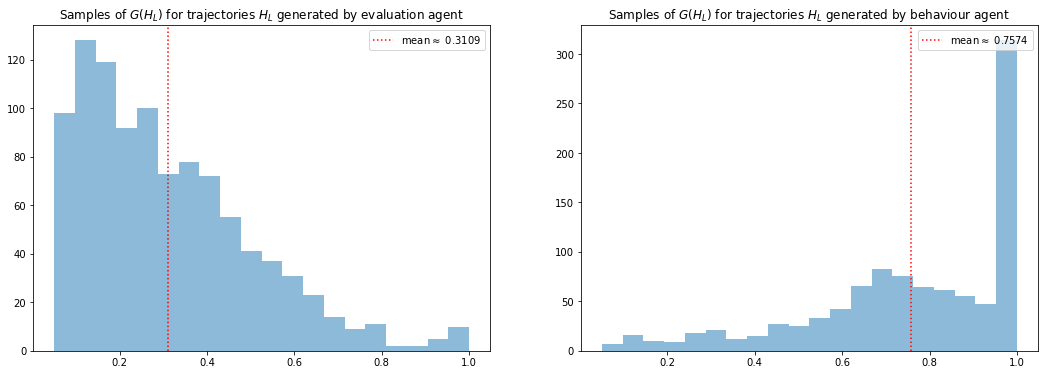

In [9]:
fig,axs =  plt.subplots(1, 2, sharex=False, figsize=(18,6))

for i,key in enumerate(rewards):
    axs[i].hist(rewards[key],bins=20,alpha=0.5)
    mu = mean(rewards[key])
    axs[i].axvline(x=mu,color='red',linestyle='dotted',label=r'mean$\approx$ ' + format(mu,'.4f'))
    axs[i].set_title(r'Samples of $G(H_L)$ for trajectories $H_L$ generated by ' + key)
    axs[i].legend(loc='upper right')
plt.show()

The goal is to estimate the mean of the random variable on the left given samples of the random variables on the right.

<h3>Estimators</h3>

We define for $\displaystyle h_{L} \sim \pi _{b}$, $\displaystyle n_{D} =:|D|$ and 

\begin{equation*}
    (*):\iff \exists \epsilon >0  \forall b\in B. \frac{\pi_e(a|s)}{\pi_b(a|s)}>\epsilon
\end{equation*}



* Simple imp. sampling (unbiased and consistent)

\begin{align*}
\hat{\rho }_{IS}( \pi _{e} |h_{L} ,\pi _{b}) & := \underbrace{\prod _{t=1}^{L}\frac{\pi _{e}( a_{t} |s_{t})}{\pi _{b}( a_{t} |s_{t})}}_{\text{importance weight}} G( H_{L}) \ \\
SIS( \pi _{e} |D) & :=\frac{1}{n_{D}}\sum _{b\in B}\hat{\rho }_{IS}( \pi _{e} |h_{L,b} ,\pi _{b})
\end{align*}

Simple to compute but large upper bound $\left(max_t \left\{\frac{\pi _{e}( a_{t} |s_{t})}{\pi _{b}( a_{t} |s_{t})}\right\}\right)^L$, thus often high variance.

* Normalized per-decision imp. sampling (unbiased and consistent if $(*)$ or $n_{D}=1$) if $\gamma<1$

\begin{align*}
\hat{\rho }_{NPDIS}( \pi _{e} |h_{L} ,\pi _{b}) & :=\frac{\sum _{i=1}^{L} \gamma ^{t-1}( R_{t} -r_{lb})\prod _{t=1}^{i}\frac{\pi _{e}( a_{t} |s_{t})}{\pi _{b}( a_{t} |s_{t})} +r_{lb}\frac{\gamma ^{L} -1}{\gamma -1} -G_{lb}}{G_{ub} -G_{lb}}\\
NPDIS( \pi _{e} |D) & :=\frac{1}{n_{D}}\sum _{b\in B}\hat{\rho }_{NPDIS}( \pi _{e} |h_{L} ,\pi _{b})
\end{align*}

Each reward $R_t-r_{lb}$ is multiplied by its own importance-weight, $R_t-r_{lb}$ ensures $NPDIS\geq 0$. Adding $r_{lb}\frac{\gamma^L-1}{\gamma-1}=G_{lb}$ is supposed to correct the bias introduced by $R_t-r_{lb}$. Often lower variance than $SIS$. Drawback: $(*)$ must hold for consistency. 

If $\gamma=1$ replace $r_{lb}\frac{\gamma^L-1}{\gamma-1}$ by $Lr_{lb}$.

* Weighted imp. sampling (biased but consistent if $(*)$ or $n_{D}=1$)

\begin{align*}
WIS( \pi _{e} |D) & =\frac{\sum _{i=1}^{n_{D}}\prod _{t=1}^{L}\frac{\pi _{e}( a_{t} |s_{t})}{\pi _{b}( a_{t} |s_{t})} G( H_{L})}{\sum _{i=1}^{n_{D}}\prod _{j=1}^{L}\frac{\pi _{e}( a_{t} |s_{t})}{\pi _{b}( a_{t} |s_{t})}}
\end{align*}

Replacing $G(H_L)$ by $G_{lb}$($G_{ub}$) gives the lower(upper) bound $0$($1$). Thus $WIS\in [0,1]$ and lower variance in comparison to $SIS,NPDIS$. Drawback biased and $(*)$ must hold for consistency. 

* Consistend weighted per-decision imp. sampling (biased but consistent if $(*)$ or $n_{D}=1$)

\begin{align*}
CWPDIS( \pi _{e} |D) & =\left(\frac{1}{G_{ub} -G_{lb}}\right)\left(\left(\sum _{t=1}^{L} \gamma ^{t-1}\frac{\sum _{i=1}^{n_{D}} R_{t}\prod _{j=1}^{t}\frac{\pi _{e}( a_{j} |s_{j})}{\pi _{b}( a_{j} |s_{j})} }{\sum _{i=1}^{n_{D}}\prod _{j=1}^{t}\frac{\pi _{e}( a_{j} |s_{j})}{\pi _{b}( a_{j} |s_{j})}}\right) -G_{lb}\right)
\end{align*}

Motivated by improvement of $SIS$ by $NPDIS$. Often lower variance in comparison to $WIS$ but same drawbacks as $WIS$.

<h3>Example: compute NPDIS</h3>

Let $\pi_e,\pi_b$ be defined as above. Let $\gamma=1$ and `max_iter`$=L=200$.

In [10]:
def npdis(e,b,G_lb=0,G_ub=None,r_lb=0,max_iter=200):
    G_ub = max_iter if G_ub==None else G_ub
    state,done,pie,pib,npdis = e.get_env().reset(),False,e.policy,b.policy,0
    weight = 1
    ctr = 0
    while(not done and ctr < max_iter):
        state = as_tensor(state,device=DEVICE)
        action = pib.get_distribution(state).sample()
        weight *= exp(pie.get_distribution(state).log_prob(action))
        weight /= exp(pib.get_distribution(state).log_prob(action))
        state,reward,done,_ = e.get_env().step(action.numpy())
        if(not done):
            npdis += (reward.item()-r_lb)*weight
        ctr += 1
    return npdis/(G_ub-G_lb)

In [11]:
NUM_SAMPLES = 1000
muG = mean(rewards['evaluation agent'])
samples = [npdis(agent,agent2) for i in tqdm(range(NUM_SAMPLES))]
mu = mean(samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.32it/s]


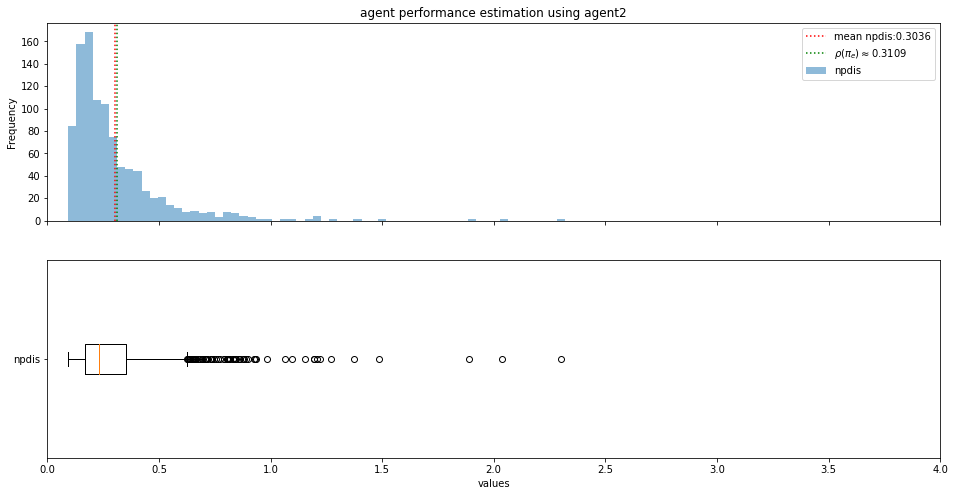

In [12]:
fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].hist(samples,bins='auto',label='npdis',alpha=0.5)
axs[0].axvline(x=mu,color='red',linestyle='dotted',label='mean npdis:'+format(mu,'.4f'))
axs[0].axvline(x=muG,color='green',linestyle='dotted',label=r'$\rho(\pi_e)\approx$'+format(muG,'.4f'))
axs[0].set_title('agent performance estimation using agent2')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Frequency')
axs[1].boxplot(samples,vert=0,labels=['npdis'])
axs[1].set_xlabel('values')
axs[1].set_xlim(0,4)
plt.show()

Observe how close our estimate and $\rho(\pi_e)$ are, although not a single trajectory was sampled by `agent`. The majority of samples underestimates $\rho(\pi_e)$, samples have a large range of values. Later we will observe that for more complex environments npdis has even larger variance. Thus a large amount of samples has to be generated to obtain proper estimates of $\rho(\pi_e)$.

<h3> Discretization of environments in SB3 </h3>

Above we assumed we assumed that $\mathcal{A},\mathcal{S}$ are finite. Some definitions above can be expanded for infinite $\mathcal{A},\mathcal{S}$, but working with the definitions above, we may need to modify environments.

<h4> Motivation: </h4>

As seen above for some estimators condition $(*)$ must hold for consistency. If all policies used are strictly positive and $|\mathcal{S}|,|\mathcal{A}|<\infty$, $(*)$ must hold, because there exist $a^*,b^*$
\begin{equation*}
\epsilon:=inf_{\mathcal{A},\mathcal{S}}\frac{\pi_e(a|s)}{\pi_b(a|s)}=min_{\mathcal{A},\mathcal{S}}\frac{\pi_e(a|s)}{\pi_b(a|s)}=\frac{\pi_e(a^*|b^*)}{\pi_b(a^*|s^*)}>0
\end{equation*}


If either the state or action space is infinite $(*)$ may not hold. One workaround is discretization of environments. If $\mathcal{S}=\prod_{i=1}^n(a_i,b_i]$ for some $a,b\in\mathbb{R}^n$, then for some finite partition $Q\subset\mathcal{P}(\mathcal{S})$ of $\mathcal{S}$, define for $s,z\in\mathcal{S}$ the equivalence relation:

\begin{equation*}
s\sim z :\iff \exists A\in\mathcal{Q}. s,z\in A
\end{equation*}

Then by identifying every state $s$ with a fixed representative of its equivalence class, one gets a modified environment, with finite $\mathcal{S}$. Applying the analogous process to $\mathcal{A}$ one can discretize the action-space.

For example the `pendulum` environment, where each action(state) corresponds to a value in an interval(product of intervals), specifically: 

 The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.
 
|Num   | Action | Min  | Max |
|:-----|:-------|:-----|:----|
| 0    | Torque | -2.0 | 2.0 |

The observation is a `ndarray` with shape `(3,)` representing the x-y coordinates of the pendulum's free end and its angular velocity.

| Num | Observation      | Min  | Max |
|:----|:-----------------|:-----|:----|
| 0   | x = cos(theta)   | -1.0 | 1.0 |
| 1   | y = sin(theta)   | -1.0 | 1.0 |
| 2   | Angular Velocity | -8.0 | 8.0 |

and $R_i\in (-16.28,0)$.
    
(Compare https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

We can use SB3's custom environments to discretize the action and state-space and then train agents using the custom environment. Define the class `DiscretePendulum`

(Custom environments in SB3: https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html)
\
(Spaces-Gym Documentation: https://mgoulao.github.io/gym-docs/content/spaces/)

In [13]:
from stable_baselines3.common.env_checker import check_env
from gym import spaces

class DiscretePendulum(gym.Env):
    """Custom Environment that follows gym interface"""
    metadata = {"render.modes": ["human"]}
    
    '''Constructor takes parameter N_DISCRETE_ACTIONS indicating number of actions'''

    def __init__(self, N_ACTIONS=5,N_OBS=20):
        super(DiscretePendulum, self).__init__()
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        
        '''Define action space with 2^n+1 actions'''
        
        self.action_space = spaces.Discrete(2**N_ACTIONS+1)
        # Example for using image as input (channel-first; channel-last also works):
        
        '''Define observation space as in the original environment'''
        
        self.observation_space = spaces.MultiDiscrete([N_OBS,N_OBS,N_OBS])
        #self.observation_space = spaces.Box(low=np.array([-1,-1,-8],dtype=np.float32), high=np.array([1,1,8],dtype=np.float32))
        
        '''Store original environment for methods we can reuse'''
        
        self.org_env = gym.make("Pendulum-v0") 
        self.N_ACTIONS = N_ACTIONS
        self.N_OBS = N_OBS
    
    '''Define step method for new action space:
    Subdivide product of intervals in cubes, choose set of cubes as Q
    '''
    
    def discrete_state(self,state):
        bin1 = np.linspace(0,1,self.N_OBS)
        bin2 = np.linspace(-8,8,self.N_OBS)
        res = []
        #state = state if state[0] is not np.ndarray else state[0]
        for i in range(len(state)):
            bin_ = np.digitize(state[i],bin2) if i==2 else np.digitize(state[i],bin1)
            res.append(bin_)
        return res

    def step(self, action):
        '''subdivide Interval into subintervals and choose set of subintervals als Q'''
        a = [-2 + 2*(action/(2**self.N_ACTIONS))] 
        s,d,r,_ = self.org_env.step(a)
        return self.discrete_state(s),d,r,_
        
    def reset(self):
        return self.discrete_state(self.org_env.reset())
        
    def render(self, mode="human"):
        self.org_env.render(mode="human")
        
    def close(self):
        self.org_env.close()
        
dp = DiscretePendulum()

Another way $(*)$ can be achieved, if $|\mathcal{A}|<\infty=|\mathcal{S}|$ (e.g. CartPole) is to choose $\epsilon\in(0,1)$ and sampling actions by doing the follwing: 

In every state $s$, sample $x\sim U[0,1],$ if $x\geq \epsilon$, choose an action $\hat{a}$, with $\hat{a}=argmax_{\mathcal{A}}(\pi(.|s))$, else choose an action uniformly at random. 

the probability $p$ of choosing an action is bounded by $\frac{\epsilon}{n}\leq p \leq 1$:

\begin{align*}
P(A_s=\hat{a})&=(1-\epsilon)\cdot P(A_s=\hat{a}|U\geq\epsilon)+\epsilon\cdot P(A_s=\hat{a}|U<\epsilon)\\
&=(1-\epsilon)\cdot 1+\epsilon\cdot\frac{1}{n}=1-\epsilon+\frac{\epsilon}{n}>\frac{\epsilon}{n}\\
P(A_s\neq \hat{a})&=1-P(A_s=\hat{a})=1-1+\epsilon-\frac{\epsilon}{n}=\frac{n-1}{n}\epsilon
\end{align*}

Thus for $a\neq\hat{a}$, $P(A_s=a)=\frac{\epsilon}{n}$. If, in some state $s$, the probability distribution $\pi(.|s)$ is close to uniform, this modification of the policy might cause massive decline in performance.

In [14]:
'''evaluation agent, total-timesteps approx. 11M'''
eval_agent = PPO.load("trained_models/PPO-evaluation-DP-17M") 
eval_agent.set_env(DiscretePendulum())

'''behaviour agents'''

'''total-timesteps approx 1.1M'''
b1_agent = PPO.load("trained_models/PPO-behaviour1-DP-1M")
b1_agent.set_env(DiscretePendulum())

'''totat-timesteps approx 1.2M'''
b2_agent = PPO.load("trained_models/PPO-behaviour2-DP-11M")
b2_agent.set_env(DiscretePendulum())

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<h2>HCOPE-Class for SB3</h2>

Define HCOPE-Class equiped with methods to compute all estimators defined above and its lower bounds. Compare to code below: 

| parameters   | description                        | attributes       | description               |
|:-------------|:-----------------------------------|:-----------------|:--------------------------|
| `eval_model` | evaluation agent                   | `discount_gamma` | $(\gamma^i)_{I=1}^L$      |
| `bhv_model`  | behaviour agents                   | `G_ub`           | $G_{ub}$ as defined above |
| `max_iter`   | $L$ length of trajectories         | `G_lb`           | $G_{lb}$ as defined above |
| `bounds`     | $(r_{lb},r_{ub})$ bounds for $R_i$ | `b_pol`          | behaviour policies        |  
| `gamma`      | discount factor                    | `e_pol`          | evaluation policy         |  
| `terminal_reward`|terminal reward | | |


First compute $\displaystyle G_{lb} ,G_{ub}$ and observe that for the correction term for `NPDIS` it holds
\begin{equation*}
npdis\_correction\ =\ r_{lb}\frac{\gamma ^{L} -1}{\gamma -1} -G_{lb} = G_{lb}-G_{lb} =  0
\end{equation*}


where $\displaystyle L=$ `max_iter`.

Compare section $3.4$ https://scholarworks.umass.edu/dissertations_2/514/ for further explanation.

In [15]:
class HCOPE():
    def __init__(self,eval_model,bhv_models,max_iter=50,bounds=(0,1),gamma=1,terminal_reward=None):
        self.e = eval_model
        self.b = bhv_models
        self.e_pol = eval_model.policy
        self.b_pol = [b.policy for b in bhv_models]
        self.nD = len(self.b_pol)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        gam = 1
        self.gamma = gamma
        self.r_lb = bounds[0]
        self.r_ub = bounds[1]
        self.max_iter = max_iter
        self.discount_gamma = [gam:=gam*gamma for x in [1]*max_iter]
        self.terminal_reward = bounds[0] if terminal_reward==None else terminal_reward
        self.G_ub = max_iter*self.r_ub if (gamma == 1) else self.r_ub*(1-self.discount_gamma[-1])/(1-gamma)
        self.G_lb = max_iter*self.r_lb if (gamma == 1) else self.r_lb*(1-self.discount_gamma[-1])/(1-gamma)

Later we will make the observation that some of the estimators defined above have large variance, thus we might want to decrease episode length $L$ so that we can generate more samples in a shorter amount of time. If $L$ changes, so do the bounds for $G$ and `discount_gamma`.

In [16]:
class HCOPE(HCOPE):
    def set_max_iter(self,new_iter):
        self.max_iter = new_iter
        
        gam = 1
        gamma = self.gamma
        self.discount_gamma = [gam:=gam*gamma for x in [1]*new_iter]
        self.G_ub = new_iter*self.r_ub if (gamma == 1) else self.r_ub*(1-self.discount_gamma[-1])/(1-gamma)
        self.G_lb = new_iter*self.r_lb if (gamma == 1) else self.r_lb*(1-self.discount_gamma[-1])/(1-gamma)

If for `_,_,done,_ = env.step(action,env,done)`, `done==False`, the agent is in the terminal state $\tilde{s}$ with terminal reward `reward`$=\tilde{r}$ and next state $\tilde{s}'=\tilde{s}$. We do this, so that for each agent each epoch has lenght $L$. Thus define:

`step(env,done) -> states_,rewards,dones,_`

`total_reward(agent) -> total_reward`

`step` is a modification of `env().step()` which models the transition into the terminal state if the environment terminates (`done=True`). `total_reward` computes the total reward for one trajectory generated by `agent`.

In [17]:
class HCOPE(HCOPE):    
    '''Take step for action a in environment=env'''
    def step(self,a,env,done):
        return (None,np.array(0),True,None) if done else (env.step(a.numpy()))
    
    '''add method for collecting empirical data about evaluation-agent performance'''
    def total_reward(self,agent,normalized=True):
        reward,ctr,done = 0,0,False
        state = agent.get_env().reset()
        pol = agent.policy
        while (not done and ctr<self.max_iter):
            state = as_tensor(state,device=self.device)
            action = pol.get_distribution(state).sample()
            state,r,done,_ = agent.get_env().step(action.numpy()) # r is reward for current step            
            reward += r.item()
            ctr += 1 
        return (reward-self.G_lb)/(self.G_ub-self.G_lb) if normalized else reward

Continue implementing importance sampling methods

In [18]:
class HCOPE(HCOPE):
    def importance_sampling(self):
        cntr,npdis,cwpdis = 0,[0]*self.nD,0
        dones = [False]*len(self.b_pol)
        states = [b.get_env().reset() for b in self.b]
        rewards,G_t,weights = zip(*([(0,0,1)]*len(self.b_pol)))
        gamma = 1

        while cntr<self.max_iter:
            states = [None if d else as_tensor(s) for s,d in zip(states,dones)]
            actions = [None if d else b.get_distribution(s).sample() for b,s,d in zip(self.b_pol,states,dones)]
            b_logs = [0 if d else b.get_distribution(s).log_prob(a).item() for s,b,a,d in zip(states,self.b_pol,actions,dones)]
            e_logs = [0 if d else self.e_pol.get_distribution(s).log_prob(a).item() for s,a,d in zip(states,actions,dones)] 
            states,rewards,dones,_ = zip(*[(self.step(a,b.get_env(),d)) for b,a,d in zip(self.b,actions,dones)])
            rewards = [self.terminal_reward if done else r.item() for r,done in zip(rewards,dones)]
            
            '''Compare formulas above'''

            G_t = [g + gamma*r for r,g in zip(rewards,G_t)]
            weights = [w*exp(e-b) for w,b,e in zip(weights,b_logs,e_logs)]
            cwpdis += gamma * (sum([w*r for w,r in zip(weights,rewards)])) / sum(weights)
            npdis = [rem+gamma*(r-self.r_lb)*w for rem,r,w in zip(npdis,rewards,weights)]
            cntr += 1
            gamma *= gamma

        G_t = [(g-self.G_lb)/(self.G_ub-self.G_lb) for g in G_t]    
        sis = mean([w*g for w,g in zip(weights,G_t)])
        npdis = mean([x/(self.G_ub-self.G_lb) for x in npdis])
        wis = self.nD*sis/sum(weights)
        cwpdis = (cwpdis-self.G_lb)/(self.G_ub-self.G_lb)
        return (sis,npdis,wis,cwpdis)
    
    def sampling(self,num_trajectories=1000):
        return [self.importance_sampling() for i in [None]*num_trajectories]

As observed above some estimators have high variance thus large samples are needed to compute tight lower bounds. Observe 

`weights`$=\left(\prod^{cntr}_{i=0}\frac{\pi_e(a_i|s_i)}{\pi_b(a_i|s_i)}\right)_{b\in B}$.

Instead of collecting `data=(states,actions,rewards,e_logs,b_logs)` for each epoch and then computing samples, as seen in the formulas above, one can compute samples iteratively. This allows us to discard `data` each step, which saves time for large $L$.

Choose $\gamma=1,L=50$. From the Pendulum documentation above, we get $R_i\in (-16.28,0)=(r_{lb},r_{ub})$. The pendulum environment does not terminate before the $200$th step, so we do not have to specify `terminal_reward`.

In [19]:
GAMMA = 1
MAX_ITER = 20 
R_LB = -16.2736044
R_UB = 0
BOUNDS = (R_LB,R_UB)

hcope = HCOPE(eval_agent, [b1_agent,b2_agent],max_iter=MAX_ITER,bounds=BOUNDS,gamma=GAMMA)

In [20]:
def load(filename):
    with open(filename, 'rb') as handle:
        temp = pickle.load(handle)
    return temp

def save(filename,var):
    with open(filename, 'wb') as handle:
        pickle.dump(var, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 156.48it/s]


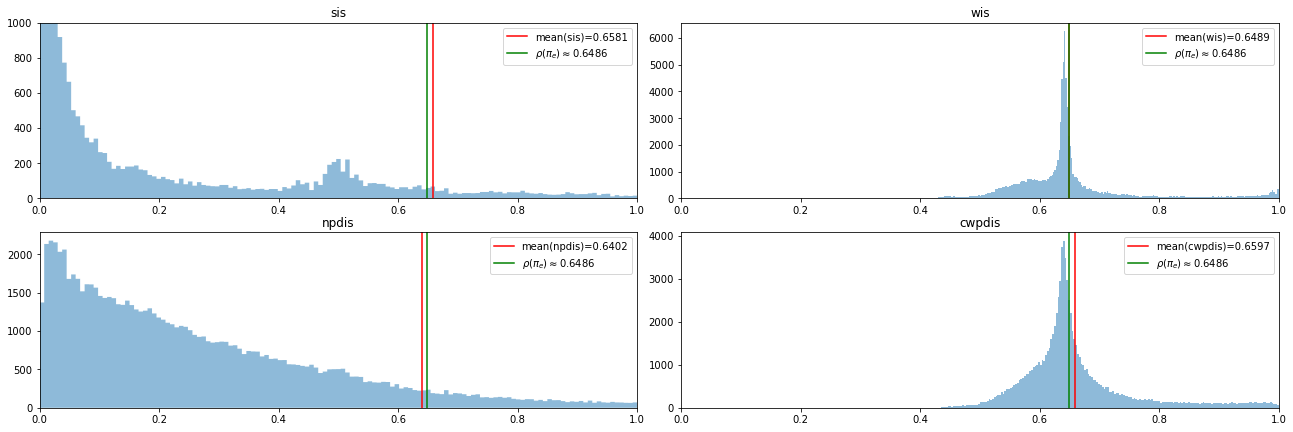

In [21]:
load_samples = True
NUM_SAMPLES = 90000

if(not load_samples):
    samples = [hcope.importance_sampling() for i in tqdm(range(NUM_SAMPLES))]
else:
    samples = load('samples/PPO-IMPS-DP-iter20-num90k2.pickle')

keys = ['sis','npdis','wis','cwpdis']
data = [list(x) for x in zip(*samples)]
samp = {k:s for k,s in zip(keys,data)}
means = {key:mean(samp[key]) for key in keys}
muG_vec = [hcope.total_reward(hcope.e) for i in tqdm(range(5000),position=0,leave=True)]
muG = mean(muG_vec)

bins = {k:'auto' for k in keys}
bins['sis'] = np.linspace(0,3,400)
bins['npdis'] = np.linspace(0,3,400)

fig,axs =  plt.subplots(2, 2, sharey=False, figsize=(18,6))
fig.tight_layout(pad=1.3)
ax = [(j,i) for i in [0,1] for j in [0,1]]

for i,key in enumerate(samp):
    l,k = ax[i]
    axs[l,k].hist(samp[key],bins = bins[key],histtype='stepfilled',alpha=0.5)
    axs[l,k].axvline(x=means[key],color='red',label='mean('+str(key)+')='+format(means[key],'.4f'))
    axs[l,k].axvline(x=muG,color='green',label=r'$\rho(\pi_e)\approx$'+format(muG,'.4f'))
    axs[l,k].set_xlim(0,10) if k==0 else None
    axs[l,k].set_title(key)
    axs[l,k].legend(loc='upper right')
    axs[l,k].set_xlim(0,1)
axs[0,0].set_ylim(0,1000)

plt.show()

Let $X\in\{SIS(\pi_e|D),NPDIS(\pi_e|D),WIS(\pi_e|D),CWPDIS(\pi_e|D)\}$ be 
The goal is to compute lower bounds for $\rho(\pi_{e})$. One way to compute tight bounds is to use confidence intervals. Confidence intervals are situated, symmetric arround the sample mean, which is an estimation of $\rho(\pi_e)$. Thus we want the sample mean to be as close to $\rho ( \pi _{e})$ as possible.

Remark: $X$ is an unbiased estimator of $\rho(\pi_e)$ if $(*)$ holds i.e. for $(X_i)_{i\in\mathbb{N}}$ i.i.d. samples of $X$, by Khintchine Strong Law of Large Numbers

\begin{equation*}
\frac{1}{n}\sum_{i=1}^nX_i\overset{a.s}\longrightarrow\rho(\pi_e).
\end{equation*}

Lets compare how quickly sample means approximate to $\rho(\pi_e)$:

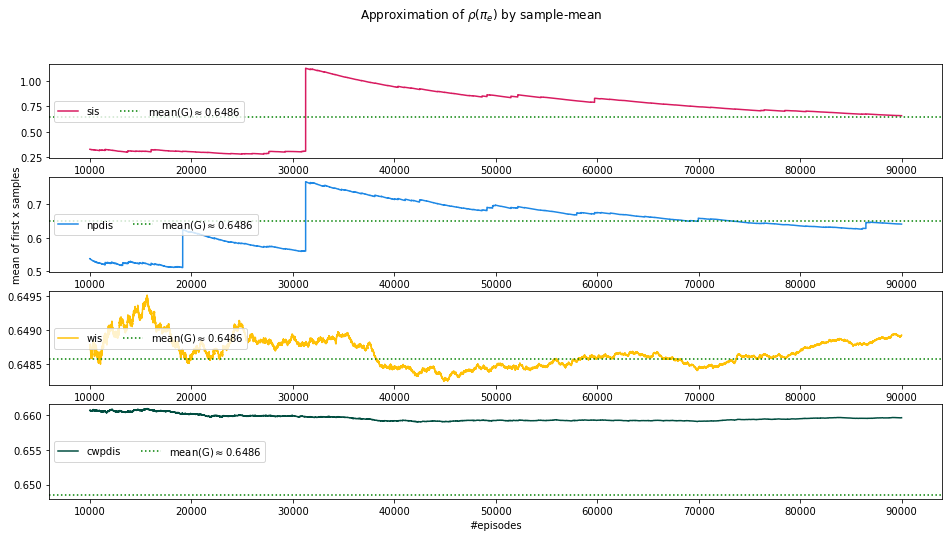

In [22]:
samp_means = {k:None for k in keys}
start,stop = 10000,90000
x = np.arange(start,stop)
for key in samp_means:
    m = 0
    samp_means[key] = [m:=(m*i+samp[key][i])/(i+1) for i in range(len(samp[key]))][start:stop]

cols = ['#D81B60','#1E88E5','#FFC107','#004D40','#4DE5AC']
fig,axs = plt.subplots(4,1,figsize=(16,8),sharey=False)
for i,key in enumerate(samp):
    axs[i].plot(x,samp_means[key],color=cols[i],label=key)
    axs[i].axhline(y=muG,label=r'mean(G)$\approx$'+format(muG,'.4f'),linestyle='dotted',color='green')
    axs[i].legend(loc='center left',ncol=2)
axs[i].set_xlabel('#episodes')
axs[1].set_ylabel('mean of first x samples')
fig.suptitle(r'Approximation of $\rho(\pi_e)$ by sample-mean')

plt.show()

<h3>Computing lower bounds</h3>

We define the class `confidence`, equipped with methods for computing confidence intervals for a given sample, i.e. we define functions $f_\delta, \delta\in (0,1)$, so that given some random random variable $X$ and random sample $(x_i)_{i\in I},\bar x = \frac{1}{n}\sum x_i$ it holds 

\begin{equation*}
\mathbb{P}\left(X>\bar x - f_\delta\left(\left(x_i\right)_{i\in I}\right)\right)>\delta
\end{equation*}

Methods include some of the algorithms discussed in https://scholarworks.umass.edu/dissertations_2/514/ beginning on page 85.

(Bootstraping) Compare section Examples: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
\
(t-CI-Interval) Compare section Methods: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

In [23]:
import random
import numpy as np
from math import sqrt
from numpy import log,mean
from scipy.stats import t,bootstrap,sem
from scipy.optimize import minimize, Bounds

class confidence():
    def __init__(self,delta):
        self.delta = delta
        
    def set_delta(self,new_delta):
        self.delta = new_delta

    def cut_estimate(self,c,X,delta,m):
        Y = [min(x,c) for x in X]
        Y_squared = [y**2 for y in Y] 
        n = len(Y)
        res = sum(Y)/n
        res -= 7*c*log(2/delta)/(3*(m-1))
        temp1 = max(0, (n*sum(Y_squared))-(sum(Y)**2))
        temp2 = log(2/delta)/m
        temp3 = 2/(n*(n-1))
        temp = temp1 * temp2 * temp3
        res -= sqrt(temp)
        return -res
    
    '''Compute lower confidence bound for sample with CUT algorithm presented in resource above'''
        
    def cut(self,sample,delta = None):
        delta = delta if delta!=None else self.delta
        np.random.shuffle(sample)
        X_pre = sample[0:int(len(sample)/5)]
        X_post = sample[int(len(sample)/5)+1:len(sample)-1]
        data = (X_pre,delta,len(X_post))
        
        c_ = minimize(fun = self.cut_estimate, x0 = (1,), args = data, method = 'L-BFGS-B', bounds = Bounds(1, float('inf')))
        
        return -self.cut_estimate(c_.x[0],X_post,delta,len(X_post))#,c_.x[0]
    
    '''Compute lower confidence bound for sample bound using bootstrap distribution'''
    
    def bca(self,sample, DELTA=None, RESAMPLES=2000,resize=10000):
        DELTA = DELTA if DELTA!=None else self.delta
        data = (sample,) if len(sample)>resize else (sample[0,resize],)
        
        '''return lower confidence bound for the mean from bootstrap confidence interval'''
        return bootstrap(data, mean, confidence_level=DELTA, n_resamples=RESAMPLES).confidence_interval.low
    
    '''Compute lower confidence bound for sample using t-distribution'''
    
    def tt(self,data):
        '''return lower confidence bound for the mean from t-dist. confidence interval'''
        return t.interval(alpha=self.delta, df=len(data)-1, loc=np.mean(data), scale=sem(data))[0]
    
    '''return lower bounds for samples generated by HCOPE.epoch
    sample = {'sis':sis,'npdis':npdis,'wis':wis,'cwpdis':cwpdis}
    '''
    
    def lower(self,sample,include_bca=False,as_tuple=True,means=False):
        if(not as_tuple):
            if(include_bca):
                ci = {'cut':self.cut,'bca':self.bca,'tt':self.tt}
            else:
                ci = {'cut':self.cut,'tt':self.tt}
                bounds = {key:None for key in ci} 
                for f in ci:
                    bounds[f] = {key:ci[f](sample[key]) for key in sample}
            return bounds
        else:
            nexact = 'approximate HCOPE / performace of evaluation policy'
            nexact_star = 'approximate HCOPE / performance of best policy'
            exact = 'exact HCOPE'
            bounds = {exact:None,nexact:None,nexact_star:None}
            bounds[exact] = (self.cut(sample['sis']),self.cut(sample['npdis']))
            bounds[nexact] = (self.tt(sample['sis']),self.tt(sample['npdis']))
            bounds[nexact_star] = (self.tt(sample['wis']),self.tt(sample['npdis']))
            if(means):
                means = {exact:[],nexact:[],nexact_star:[]}
                means[exact] = (mean(sample['sis']),mean(sample['npdis']))
                means[nexact] = (mean(sample['sis']),mean(sample['npdis']))
                means[nexact_star] = (mean(sample['wis']),mean(sample['npdis']))
            return bounds if not means else bounds,means
    
DELTA = 0.95
conf = confidence(DELTA)

Now compute confidence intervals for the samples generated above (exclude BCa because of large sample size).

In [24]:
DELTA = 0.9
conf = confidence(DELTA)
bounds = conf.lower(samp,as_tuple=False)

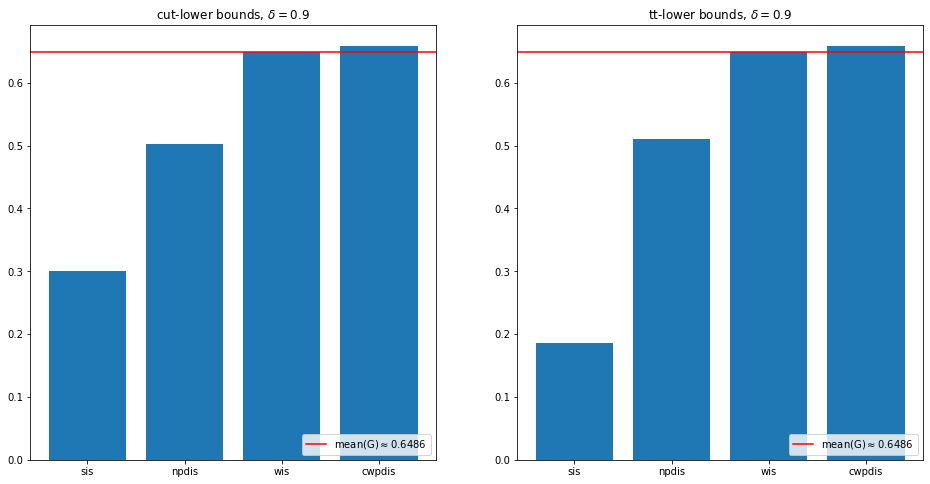

In [25]:
fig,axs = plt.subplots(1,2,figsize=(16,8))
for i,key in enumerate(bounds):
    D = bounds[key]
    axs[i].bar(range(len(D)), list(D.values()), align='center')
    axs[i].set_xticks(range(len(D)))
    axs[i].set_xticklabels(list(D.keys()))
    axs[i].set_title(key+r'-lower bounds, $\delta=$'+str(DELTA))
    axs[i].axhline(y=muG,color='red',label=r'mean(G)$\approx$'+format(muG,'.4f'))
    axs[i].legend(loc='lower right')

Now visualise how sample size influences lower bounds. We will use combinations of importance sampling methods  and confidence intervals recommended on p.140 (https://scholarworks.umass.edu/dissertations_2/514/) (replacing BCa with TT because of large sample size).

In [26]:
nexact = 'approximate HCOPE / performace of evaluation policy'
nexact_star = 'approximate HCOPE / performance of best policy'
exact = 'exact HCOPE'

num_steps = 150

plot_bounds = {exact:[],nexact:[],nexact_star:[]}
plot_means = {exact:[],nexact:[],nexact_star:[]}

for i in tqdm(range(num_steps)):
    data = {key:samp[key][:int(NUM_SAMPLES*(i+1)/num_steps)] for key in samp}
    bounds,means = conf.lower(data,means=True)
    for k in plot_bounds:
        plot_bounds[k].append(bounds[k])
        plot_means[k].append(means[k])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [05:28<00:00,  2.19s/it]


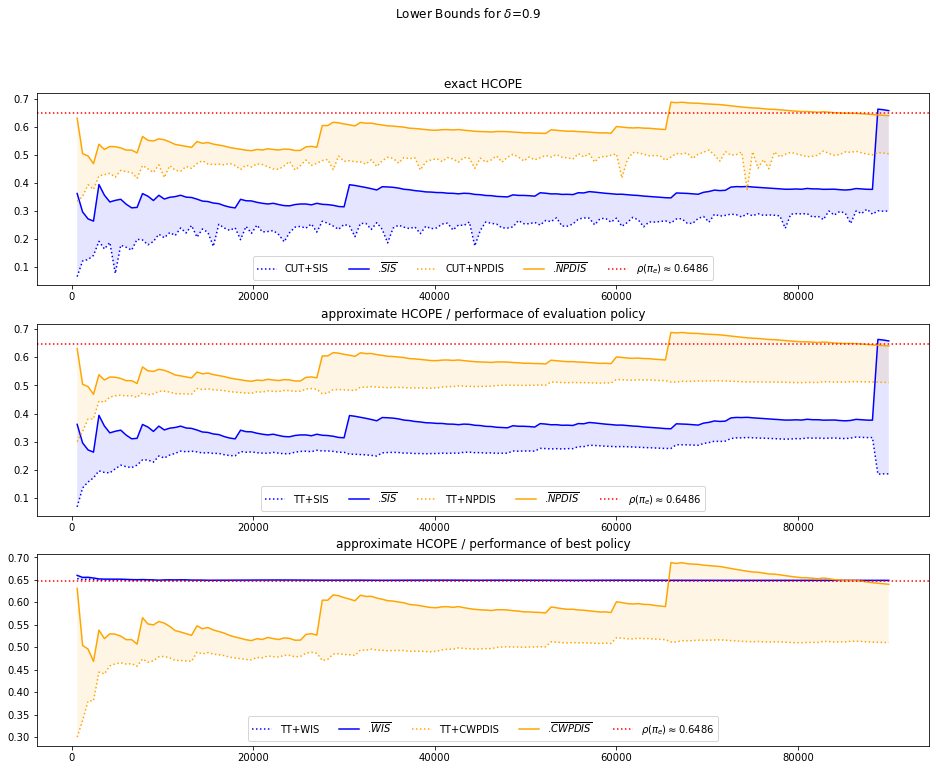

In [27]:
fig,axs = plt.subplots(3,1,figsize=(16,12))
x = [int(NUM_SAMPLES*(i+1)/num_steps)  for i in range(num_steps)]
lab = {exact:('CUT+SIS','CUT+NPDIS'),nexact:('TT+SIS','TT+NPDIS'),nexact_star:('TT+WIS','TT+CWPDIS')}
lab_mu = {exact:(r".$\overline{SIS}$",r".$\overline{NPDIS}$"),
          nexact:(r".$\overline{SIS}$",r".$\overline{NPDIS}$"),
          nexact_star:(r".$\overline{WIS}$",r".$\overline{CWPDIS}$")}

for i,k in enumerate(lab):
    mu_a,mu_b = zip(*plot_means[k])
    bound_a,bound_b = zip(*plot_bounds[k])
    axs[i].plot(x,bound_a,label=lab[k][0],linestyle='dotted',color='blue')
    axs[i].plot(x,mu_a,color='blue',label=lab_mu[k][0])
    axs[i].fill_between(x,bound_a,mu_a,alpha=0.1,facecolor='blue')
    axs[i].plot(x,bound_b,label=lab[k][1],linestyle='dotted',color='orange')
    axs[i].plot(x,mu_b,color='orange',label=lab_mu[k][1])
    axs[i].fill_between(x,bound_b,mu_b,alpha=0.1,facecolor='orange')
    axs[i].axhline(y=muG,label=r'$\rho(\pi_e)\approx$'+format(muG,'.4f'),color='red',linestyle='dotted')
    axs[i].legend(loc='lower center',ncol=5)
    axs[i].set_title(k)
plt.suptitle(r'Lower Bounds for $\delta$=' + str(DELTA))
plt.show()

Where $\overline{X}$ denotes the sample mean.

<h3>(Optional) Vectorize environments for faster training</h3>

In [28]:
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = DiscretePendulum()
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

#if __name__ == "__main__":
env_id = None
num_cpu = 4  # Number of processes to use
# Create the vectorized environment
env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])# Stable Baselines provides you with make_vec_env() helper